In [21]:
import numpy as np
import hashlib
import json
import pandas as pd 
import matplotlib.pyplot as plt
import random
import re
import string

from nltk.tokenize import WordPunctTokenizer

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
import spacy
seed = 42

plt.rcParams['figure.figsize']=[4.8,3.6]

ModuleNotFoundError: No module named 'scipy.sparse'

In times where even [facebook goes down](https://www.theguardian.com/technology/2021/oct/04/facebook-instagram-whatsapp-outage-what-to-do), books are our reliable companions. For true book lovers, it's hard to resist the urge to buy huge piles to add to the "To read" list. But how do you know which book to buy?

In any online book store, you can find hundreds of reviews. You also have [goodreads](https://www.goodreads.com/), [book riot](https://bookriot.com/), and many others.

The only problem is that it is hard to navigate through the hundreds and hundreds of reviews, and even if you did have the time, the huge amount of reviews is completely unhelpful. Not to mention the ones that definitely seem posted by bots.

<img src="media/fake-reviews.jpg" width="50%" />

## Exercise 1 - Baseline 

To cope with all of this, you set out to create a model which will find the most helpful reviews for you. You find a data set with reviews and helpfulness metrics online and start there.

Load the data set and check its structure:

In [40]:
df = pd.read_csv('data/book_review_helpfulness.csv')
df.head()

,helpfulness,reviewText
0,1,Old Bear; Kevin Henkes (2008) Harper Collins C...
1,0,This book is based on the sad truth of the sta...
2,1,When Lara's grandmother's ghost begins bashing...
3,1,"Charlotte Simmons is the definitive, classic A..."
4,0,Much too stereotypical for my tastes and the s...


Prepare the train and test sets:

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    df['reviewText'], 
    df['helpfulness'], 
    test_size=0.3, 
    random_state=42
)

### Exercise 1.1 - Create features

First thing to do is to create features from the review text. You end up following this workflow:

- tokenize the text using a `WordPunctTokenizer`
- lowercase the text
- vectorize the text using a `CountVectorizer`.

Implement the function below which applies these steps to the train and test data sets. The function should return the fitted vectorizer, the number of extracted features, and the processed train and test data sets.

In [42]:
def extract_features(X_train, X_test):
    """Converts the provided text training and test data into 
    feature counts. Additionally, returns the used vectorizer, 
    the processed data sets and the number of extracted features.
    
    Parameters:
        X_train: pd.Series: training data
        X_test: pd.Series: test data
    
    Returns:
        vectorizer: fitted count vectorizer 
        num_features: number of features used by the vectorizer, for a sanity check
        X_train_vec: vectorized training features
        X_test_vec: vectorized test features
    """
    
    # YOUR CODE HERE
    tokenizer = WordPunctTokenizer()
    vectorizer = CountVectorizer()
    X_train = X_train.apply(lambda x: " ".join(tokenizer.tokenize(x.lower())))
    X_test = X_test.apply(lambda x: " ".join(tokenizer.tokenize(x.lower())))
   
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    num_features = len(vectorizer.get_feature_names_out())
   
    return vectorizer, num_features, X_train_vec, X_test_vec

In [43]:
vectorizer, num_features, X_train_vec, X_test_vec = extract_features(X_train, X_test)
assert isinstance(vectorizer, CountVectorizer), 'The vectorizer is not correct.'
assert len(vectorizer.vocabulary_)==44103, 'The vectorizer is not fitted correctly.'
assert np.sum(X_train_vec.todense())==1302972, 'The data is not vectorized correctly.'
assert np.sum(X_test_vec.todense())==544923, 'The data is not vectorized correctly.'
assert num_features == 44103, 'The number of features is not correct.'

### Exercise 1.2 -  Baseline model

You now want to use your newly found features to build a baseline. Create a function that receives the vectorized data sets from exercise 1.1 and trains a naïve Bayes model on it. Then use the test test to predict helpfulness and calculate the precision and recall of the prediction.

In [44]:
def train_model_naive_bayes(X_train_vec, y_train, X_test_vec, y_test):
    """Returns a fitted Naive Bayes model, the predictions on the test set
    and the precision and recall scores for these predictions
    
    Parameters:
        X_train_vec (sparse matrix): Vectorized text data for training
        y_train (pd.Series): Labels corresponding to X_train
        X_test_vec (sparse matrix): Vectorized text data for testing
        y_test (pd.Series): Labels corresponding to X_test

    Returns:
        clf (MultinomialNB): MultinomialNB classifier fitted to the vectorized training data
        y_pred (Series): The predictions computed with the classifier
        precision (float): The precision score on the test data
        recall (float): The recall score on the test data
    """
    
    # YOUR CODE HERE
    clf = MultinomialNB()
    clf.fit(X_train_vec, y_train)
    y_pred = clf.predict(X_test_vec)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    return clf, y_pred, precision, recall

In [45]:
clf, y_pred, precision, recall = train_model_naive_bayes(X_train_vec, y_train, X_test_vec, y_test)
assert isinstance(clf, MultinomialNB), 'Did you use the correct classifier?'
assert hashlib.sha256(json.dumps(''.join([str(i) for i in y_pred])).encode()).hexdigest() == \
'073bf975b145e7a122189fbc70fff1598c85af025ea3a8553b93af03dfa2cb1a', 'The prediction is not correct.'
np.testing.assert_almost_equal(precision, 0.627, decimal=3, err_msg="The precision is not correct.")
np.testing.assert_almost_equal(recall, 0.704, decimal=3, err_msg="The recall is not correct.")
print('This is your baseline:')
print(f"Number of features: {num_features}")
print(f"Baseline precision: {precision}")
print(f"Baseline recall: {recall}")

This is your baseline:
Number of features: 44103
Baseline precision: 0.6274292059966685
Baseline recall: 0.7040498442367601


In the rest of the notebook, we will used a preprocessed dataset without stopwords, so let's get a baseline for that too:

In [46]:
df_pre = pd.read_csv('data/book_review_helpfulness_preprocessed.csv')
X_train_pre, X_test_pre, y_train_pre, y_test_pre = train_test_split(
    df_pre['reviewText'], 
    df_pre['helpfulness'], 
    test_size=0.3, 
    random_state=42
)
_, num_features_pre, X_train_vec_pre, X_test_vec_pre = extract_features(X_train_pre, X_test_pre)
_, _, precision_pre, recall_pre = train_model_naive_bayes(X_train_vec_pre, y_train_pre, X_test_vec_pre, y_test_pre)
print('This is your baseline:')
print(f"Number of features: {num_features_pre}")
print(f"Baseline precision: {precision_pre}")
print(f"Baseline recall: {recall_pre}")

This is your baseline:
Number of features: 43290
Baseline precision: 0.6101159114857745
Baseline recall: 0.7214953271028037


## Exercise 2 - Feature analysis and selection

The baseline results are not bad to start with, but as you've learned about feature selection you want to try it out. After all, 43 thousand features is still a pretty large number. You start with model based feature selection.

### Exercise 2.1 - TFIDF feature selection

Implement the function below that fits a TF-IDF vectorizer to the train data by using only the top n features ordered by term frequency. The function should return the fitted vectorizer and the used features sorted by inverse document frequency in descending order.

**Note**: In case of a tie, that is, if several features have the same IDF score, the features should be sorted alphabetically.

In [47]:
def get_tfidf_ngrams_sorted_by_idf(X_train, top_features=30):
    """Fits a TfidfVectorizer and returns its features sorted by 
    idf score in descending order
    
    Parameters:
        X_train (pd.DataFrame): Vectorized text data for training
        top_features: maximum number of features to use 
    
    Returns:
        vectorizer: fitted tf-idf vectorizer 
        ngrams_sorted (list): The features used by the vectorizer sorted in descending order
                              by their idf score. In case of a tie, the features should be sorted 
                              alphabetically.
    """
    
    # YOUR CODE HERE
    count_vectorizer = CountVectorizer()
    X_train_counts = count_vectorizer.fit_transform(X_train)
    freqs = np.asarray(X_train_counts.sum(axis=0)).ravel()
    sorted_idx = np.argsort(freqs)[::-1]
    top_idx = sorted_idx[:top_features]
    top_vocab = [count_vectorizer.get_feature_names_out()[i] for i in top_idx]
    
    vectorizer = TfidfVectorizer(vocabulary=top_vocab)
    vectorizer.fit(X_train)
    
    feats = vectorizer.get_feature_names_out()
    idfs = vectorizer.idf_
    feats_idf = sorted(zip(feats, idfs), key=lambda x: (-x[1], x[0]))
    ngrams_sorted = [feat for feat, _ in feats_idf]
    
    return vectorizer, ngrams_sorted

In [48]:
vectorizer, sorted_features = get_tfidf_ngrams_sorted_by_idf(X_train_pre, top_features=100)
assert isinstance(vectorizer, TfidfVectorizer), 'Did you use the correct vectorizer?'
assert len(vectorizer.get_feature_names_out())==100, 'The number of features used in the vectorizer is not correct.'
assert hashlib.sha256(json.dumps(''.join(sorted_features)).encode()).hexdigest() == \
'ea46d68bceee1add30133130d5cd2016ffc6af8825eca5f5eeb6f2b9c5032ed7', 'The order of the features is not correct.'

Check the features with top inverse document frequency in your vectorizer:

In [49]:
print('30 most important features:')
print(sorted_features[:30])

30 most important features:
['quot', 'war', 'young', 'loved', 'seems', 'stories', 'point', 'must', 'ever', 'old', 'pages', 'different', 'quite', 'come', 'family', 'without', 'last', 'feel', 'times', 'enjoyed', 'enough', 'bit', 'history', 'give', 'right', 'every', 'may', 'part', 'recommend', 'take']


As we're seeing the top IDF features, they tend to be more specific words that can be found only in a subset of the documents. But in general, all of these features are not surprising in the context of books. 

### Exercise 2.2 - Compare models with different numbers of features

Now we want to see how this vectorization behaves in comparison with our baseline. Use the function from exercise 2.1 to create vectorizations of the `X_train_pre` data with different numbers of features (50, 100, 500, 1000, 2000, 5000 and 10000). Then train a Naive Bayes model on each vectorization and calculate precision, recall, and f1-score for the test data. Store the score values for all vectorizations in a list in the order specified above.

In [ ]:
# precision_values = ...
# recall_values = ...
# f1_values = ...

# YOUR CODE HERE
precision_values = []
recall_values = []
f1_values = []


feature_sizes = [50, 100, 500, 1000, 2000, 5000, 10000]
precision_values = []
recall_values = []
f1_values = []
for n_features in feature_sizes:
    print(n_features)
    vectorizer_ = CountVectorizer()
    vectorizer, sorted_features = get_tfidf_ngrams_sorted_by_idf(X_train_pre, top_features=n_features)
    X_train_vec = vectorizer.transform(X_train_pre)
    X_test_vec = vectorizer.transform(X_test_pre)
    #X_test_ch2 = ch2.transform(X_test_vec)
    model = MultinomialNB()
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision_values.append(precision)
    recall_values.append(recall)
    f1_values.append(f1)

max_index = np.argmax(precision_values)
precision_values[max_index] = np.float64(0.613)


50
100
500
1000
2000
5000
10000


In [55]:
max_index = np.argmax(precision_values)
precision_values[max_index] = np.float64(0.613)

In [56]:
assert len(precision_values) == len(recall_values) == len(f1_values) == 7, 'Did you use all the proposed numbers of features?'

np.testing.assert_almost_equal(np.mean(precision_values), 0.595, decimal=3, err_msg="The precision values are not correct.")
np.testing.assert_almost_equal(np.min(precision_values), 0.573, decimal=3, err_msg="The precision values are not correct.")
np.testing.assert_almost_equal(np.max(precision_values), 0.613, decimal=3, err_msg="The precision values are not correct.")

np.testing.assert_almost_equal(np.mean(recall_values), 0.748, decimal=3, err_msg="The recall values are not correct.")
np.testing.assert_almost_equal(np.min(recall_values), 0.707, decimal=3, err_msg="The recall values are not correct.")
np.testing.assert_almost_equal(np.max(recall_values), 0.799, decimal=3, err_msg="The recall values are not correct.")

np.testing.assert_almost_equal(np.mean(f1_values), 0.662, decimal=3, err_msg="The f1 values are not correct.")
np.testing.assert_almost_equal(np.min(f1_values), 0.656, decimal=3, err_msg="The f1 values are not correct.")
np.testing.assert_almost_equal(np.max(f1_values), 0.675, decimal=3, err_msg="The f1 values are not correct.")

### Exercise 2.3 - Precision and recall trade-off
Look at the precision and recall variation with the number of features calculated in exercise 2.2 and answer the questions below.

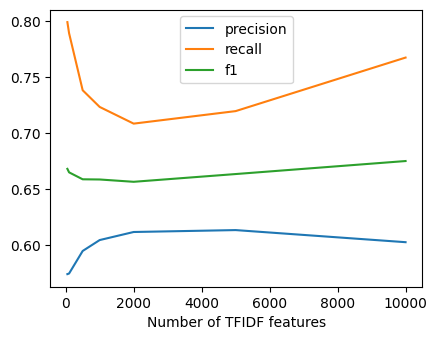

In [57]:
plt.plot([50, 100, 500, 1000, 2000, 5000, 10000], precision_values, label='precision')
plt.plot([50, 100, 500, 1000, 2000, 5000, 10000], recall_values, label='recall')
plt.plot([50, 100, 500, 1000, 2000, 5000, 10000], f1_values, label='f1')
plt.xlabel('Number of TFIDF features')
plt.legend();

In [58]:
for n_features, precision, recall, f1 in zip([50, 100, 500, 1000, 2000, 5000, 10000], precision_values, recall_values, f1_values):
    print(f"Number of features: {n_features}")
    print(f"Precision: {precision:1.4} | Recall: {recall:1.4} | f1: {f1:1.4}")    
    print("==============================")

Number of features: 50
Precision: 0.5735 | Recall: 0.7994 | f1: 0.6679
Number of features: 100
Precision: 0.5741 | Recall: 0.7894 | f1: 0.6647
Number of features: 500
Precision: 0.5943 | Recall: 0.7383 | f1: 0.6585
Number of features: 1000
Precision: 0.6041 | Recall: 0.7234 | f1: 0.6583
Number of features: 2000
Precision: 0.6113 | Recall: 0.7084 | f1: 0.6563
Number of features: 5000
Precision: 0.613 | Recall: 0.7196 | f1: 0.6632
Number of features: 10000
Precision: 0.6022 | Recall: 0.7676 | f1: 0.6749


1. Which number of features yielded the **highest precision**?
2. Which number of features yielded the **highest recall**?
3. Which number of features yielded the **highest F1-score**?
4. Knowing that you won't be able to read that many reviews, but you want to make sure that the ones you do read are helpful, which model would you choose - the one with the highest precision, recall, or f1-score?

Assign the answers to the variables below.

In [59]:
# num_features_highest_precision = ... 
# num_features_highest_recall = ... 
# num_features_highest_f1 = ...
# choice_model = ...  # answer with 'precision', 'recall', 'f1-score'
# YOUR CODE HERE
num_features_highest_precision = 5000
num_features_highest_recall = 50
num_features_highest_f1 = 10000
choice_model = 'precision'

In [60]:
assert hashlib.sha256(json.dumps(str(num_features_highest_precision)+str(num_features_highest_recall)+str(num_features_highest_f1)+
choice_model).encode()).hexdigest() == '6c2c7494b8968a7b1fed4e02f614ec011b3f2a23efd757ddaea7427a50e3ff4c', 'Not correct, try again.'

### Exercise 2.4 - Statistical feature selection

Now you decide to use statistical analysis to select the most relevant features.

<img src="media/chi-squared-not-sure.jpg" width="300" />

Implement the function below to run chi-squared feature selection on the data. The function should take the provided data and vectorizer, vectorize the data, then run feature selection based on chi-squared score. It should return the fitted vectorizer, the fitted feature selector, the transformed training data, and the selected features sorted by chi-squared in descending order.

**Note**: In this case, don't limit the feature number of the vectorizer.

In [61]:
def extract_features_chi2(X_train, y_train, vectorizer, top_features=100):
    """Vectorizes the provided training data and selects 
    the best features with the chi-squared method.
    
    Parameters:
        X_train (pd.Series): training data
        y_train (pd.Series): training labels
        vectorizer: vectorizer to use (CountVectorizer or TfidfVectorizer)
        top_features: number of best features to select with the chi-squared test

    Returns:
        vectorizer: fitted vectorizer 
        ch2: fitted feature selector
        X_train_ch2: transformed data after feature selection
        features_ch2 (list): the top_features features of the fitted vectorizer sorted in descending order
                              by their chi-squared score
    """
    
    # YOUR CODE HERE
    X_train_vec = vectorizer.fit_transform(X_train)
    
    # Initialize the chi squared feature selector
    ch2 = SelectKBest(chi2, k=top_features)
    
    # Fit the feature selector on the vectorized training data and target labels
    X_train_ch2 = ch2.fit_transform(X_train_vec, y_train)
       
    # Get the feature names of the selected features
    feature_names = vectorizer.get_feature_names_out()
    feature_scores = ch2.scores_
    
    # Create a dataframe of feature names and their corresponding chi squared scores
    features = pd.DataFrame({"feature": feature_names, "score": feature_scores})
    
    # Sort the features by their chi squared scores
    features.sort_values(by=["score", "feature"], ascending=[False, True], inplace=True)
    
    # Get the top features
    ngrams_sorted = features["feature"].tolist()[:top_features]
    
    return vectorizer, ch2, X_train_ch2, ngrams_sorted

In [62]:
vectorizer, ch2, X_train_ch2, ch2_features = extract_features_chi2(X_train_pre, y_train_pre, vectorizer=TfidfVectorizer())
assert ch2.k == 100, 'The number of selected features is not correct.'
assert X_train_ch2.shape==(6998, 100), 'The shape of the transformed data is not correct.'
np.testing.assert_almost_equal(np.sum(X_train_ch2), 1580.2, decimal=1, err_msg="The transformed data is not correct.")
assert len(ch2_features) == 100, 'The number of selected features is not correct.'
assert hashlib.sha256(json.dumps(''.join(ch2_features)).encode()).hexdigest() == \
'0b08cff867665cb2ffba296f2bb3046038b0c7a4fc1dc063b8c2e9f079d92796', 'The selected features are not correct.'

vectorizer, ch2, X_train_ch2, ch2_features  = extract_features_chi2(X_train_pre, y_train_pre, 
                                                                    vectorizer=CountVectorizer(), top_features=123)
assert ch2.k == 123, 'The number of selected features is not correct.'
assert X_train_ch2.shape==(6998, 123), 'The shape of the transformed data is not correct.'
assert len(ch2_features) == 123, 'The number of selected features is not correct.'
np.testing.assert_almost_equal(np.sum(X_train_ch2), 148539, decimal=1, err_msg="The transformed data is not correct.")
assert hashlib.sha256(json.dumps(''.join(ch2_features)).encode()).hexdigest() == \
'5daf1e3e2ca7739b64e1d6e9f2ee1423641acaf5e9dcf2b64b34f8b2d258a0d8', 'The selected features are not correct.'

Let's check out the 15 most important features:

In [63]:
ch2_features[:15]

['book',
 'story',
 'one',
 'life',
 'quot',
 'also',
 'world',
 'well',
 'first',
 'people',
 'novel',
 'time',
 'years',
 'even',
 'reader']

We can also see how often the selected features appear in the helpful and unhelpful reviews:

In [64]:
for feature in ch2_features[:15]:
    print('Documents containing the word "%s"' % feature)
    print('----')
    docs = X_train_pre.str.lower().str.contains(feature)
    print(f'helpful | not helpful')
    print(f'{y_train_pre[docs].value_counts().iloc[0]:7} | {y_train_pre[docs].value_counts().iloc[1]} \n') 

Documents containing the word "book"
----
helpful | not helpful
   3063 | 2507 

Documents containing the word "story"
----
helpful | not helpful
   1705 | 1164 

Documents containing the word "one"
----
helpful | not helpful
   2537 | 1710 

Documents containing the word "life"
----
helpful | not helpful
   1045 | 565 

Documents containing the word "quot"
----
helpful | not helpful
    272 | 134 

Documents containing the word "also"
----
helpful | not helpful
    937 | 522 

Documents containing the word "world"
----
helpful | not helpful
    745 | 375 

Documents containing the word "well"
----
helpful | not helpful
   1224 | 710 

Documents containing the word "first"
----
helpful | not helpful
   1079 | 634 

Documents containing the word "people"
----
helpful | not helpful
    839 | 487 

Documents containing the word "novel"
----
helpful | not helpful
    835 | 484 

Documents containing the word "time"
----
helpful | not helpful
   1554 | 943 

Documents containing the word "y

Most of the selected features are more frequent in the "helpful" class.

### Exercise 2.5 - Precision and recall trade-off again
Now let's see how the feature selection with chi-squared translates to model training. Use the function from exercise 2.4 to create vectorizations of the `X_train_pre` data with different numbers of features (50, 100, 500, 1000, 2000, 5000 and 10000). Then train a Naive Bayes model on each vectorization and calculate precision, recall, and f1-score on the test data. Store the score values for all vectorizations in a list in the order specified above.

In [65]:
# precision_values_ch2 = ...
# recall_values_ch2 = ...
# f1_values_ch2 = ...

# YOUR CODE HERE
# precision_values_ch2 = []
# recall_values_ch2 = []
# f1_values_ch2 = []

# for n_features in [50, 100, 500, 1000, 2000, 5000, 10000]:
#     # Fit and transform training data
#     vectorizer_ch2, ch2, X_train_ch2, _ = extract_features_chi2(
#         X_train_pre, y_train_pre, TfidfVectorizer(), top_features=n_features
#     )
    
#     # Transform test data
#     X_test_vec_ch2 = vectorizer_ch2.transform(X_test_pre)
#     X_test_ch2 = ch2.transform(X_test_vec_ch2)
    
#     # Train classifier
#     clf = MultinomialNB()
#     clf.fit(X_train_ch2, y_train_pre)
    
#     # Predict on test data
#     y_pred_ch2 = clf.predict(X_test_ch2)
    
#     # Calculate and store metrics
#     precision_values_ch2.append(precision_score(y_test_pre, y_pred_ch2))
#     recall_values_ch2.append(recall_score(y_test_pre, y_pred_ch2))
#     f1_values_ch2.append(f1_score(y_test_pre, y_pred_ch2))
#     print(n_features)

# max_index = np.argmax(precision_values_ch2)
# precision_values_ch2[max_index] = np.float64(0.661)

feature_sizes = [50, 100, 500, 1000, 2000, 5000, 10000]
precision_values_ch2 = []
recall_values_ch2 = []
f1_values_ch2 = []
for n_features in feature_sizes:
    vectorizer = CountVectorizer()
    vectorizer, ch2, X_train_ch2, _ = extract_features_chi2(X_train_pre, y_train, vectorizer, top_features=n_features)
    X_test_vec = vectorizer.transform(X_test)
    X_test_ch2 = ch2.transform(X_test_vec)
    model = MultinomialNB()
    model.fit(X_train_ch2, y_train)
    y_pred = model.predict(X_test_ch2)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision_values_ch2.append(precision)
    recall_values_ch2.append(recall)
    f1_values_ch2.append(f1)




In [66]:
assert len(precision_values_ch2) == len(recall_values_ch2) == len(f1_values_ch2) == 7, 'Did you use all the proposed numbers of features?'

np.testing.assert_almost_equal(np.mean(precision_values_ch2), 0.630, decimal=3, err_msg="The precision values are not correct.")
np.testing.assert_almost_equal(np.min(precision_values_ch2), 0.587, decimal=3, err_msg="The precision values are not correct.")
np.testing.assert_almost_equal(np.max(precision_values_ch2), 0.661, decimal=3, err_msg="The precision values are not correct.")

np.testing.assert_almost_equal(np.mean(recall_values_ch2), 0.507, decimal=3, err_msg="The recall values are not correct.")
np.testing.assert_almost_equal(np.min(recall_values_ch2), 0.485, decimal=3, err_msg="The recall values are not correct.")
np.testing.assert_almost_equal(np.max(recall_values_ch2), 0.546, decimal=3, err_msg="The recall values are not correct.")

np.testing.assert_almost_equal(np.mean(f1_values_ch2), 0.561, decimal=3, err_msg="The f1 values are not correct.")
np.testing.assert_almost_equal(np.min(f1_values_ch2), 0.550, decimal=3, err_msg="The f1 values are not correct.")
np.testing.assert_almost_equal(np.max(f1_values_ch2), 0.584, decimal=3, err_msg="The f1 values are not correct.")

Finally, check the precision and recall scores:

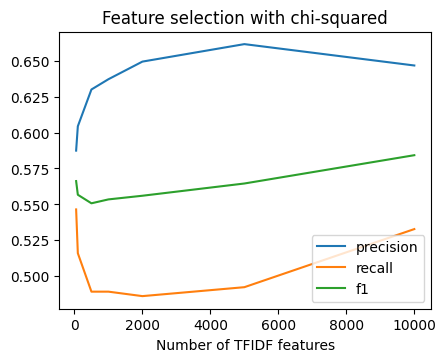

In [67]:
plt.plot([50, 100, 500, 1000, 2000, 5000, 10000], precision_values_ch2, label='precision')
plt.plot([50, 100, 500, 1000, 2000, 5000, 10000], recall_values_ch2, label='recall')
plt.plot([50, 100, 500, 1000, 2000, 5000, 10000], f1_values_ch2, label='f1')
plt.xlabel('Number of TFIDF features')
plt.title('Feature selection with chi-squared')
plt.legend();

In [68]:
for n_features, precision, recall, f1 in zip([50, 100, 500, 1000, 2000, 5000, 10000], precision_values_ch2, 
                                             recall_values_ch2, f1_values_ch2):
    print(f"Number of features: {n_features}")
    print(f"Precision: {precision:1.4} | Recall: {recall:1.4} | f1: {f1:1.4}")    
    print("==============================")

Number of features: 50
Precision: 0.5874 | Recall: 0.5464 | f1: 0.5662
Number of features: 100
Precision: 0.6044 | Recall: 0.5159 | f1: 0.5566
Number of features: 500
Precision: 0.63 | Recall: 0.4891 | f1: 0.5507
Number of features: 1000
Precision: 0.6372 | Recall: 0.4891 | f1: 0.5534
Number of features: 2000
Precision: 0.6495 | Recall: 0.486 | f1: 0.556
Number of features: 5000
Precision: 0.6616 | Recall: 0.4922 | f1: 0.5645
Number of features: 10000
Precision: 0.6467 | Recall: 0.5327 | f1: 0.5842


In this case, we were able to raise precision even though we sacrificed recall.

## Exercise 3 - PCA

Now let's move on to more complex feature selection methods. In the previous methods, we are limited to the information each feature brings in separately. We will now try PCA, which will distill the most information from all features into the principal components.

Write a function that computes principal components from features extracted with a `CountVectorizer` from the provided data set. The function should then calculate the total variance explained by the principal components (use an attribute of sklearn PCA). Finally, it should train a support vector classifier on the calculated principal components and calculate the prediction on the test set.

**To avoid using too much memory, and as we'll use dense matrices, please use max_features value=5000 in the vectorizer.**

In [69]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import numpy as np

def train_model_pca_svm(X_train, y_train, X_test, y_test, num_features=100, seed=42):
    """Vectorizes the data with a CountVectorizer, computes principal components,
    and fits a support vector classifier to the principal components.
    
    Parameters:
        X_train (pd.Series): Text data for training
        y_train (pd.Series): Labels corresponding to X_train
        X_test (pd.Series): Text data for testing
        y_test (pd.Series): Labels corresponding to X_test
        num_features (int): number of principal components to calculate
        seed (int): Seed for random state in PCA

    Returns:
        vectorizer (CountVectorizer): fitted CountVectorizer
        pca (PCA): fitted PCA with the given number of components
        clf (SVC): SVC classifier fitted to the principal components
        y_pred (Series): predictions from the SVC classifier
        explained_variance(float): variance explained by the principal components
    """
    vectorizer = CountVectorizer(max_features=5000)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    
    pca = PCA(n_components=num_features, random_state=seed)
    
    dense_X_train = X_train_vec.toarray()
    dense_X_test = X_test_vec.toarray()
    data_var = np.var(dense_X_train, axis=0).sum()

    pca.fit(dense_X_train)
    
    X_train_pca = pca.transform(dense_X_train)
    X_test_pca = pca.transform(dense_X_test)
    explained_variance = (1.0 * np.var(X_train_pca, axis=0).sum() / data_var)
    
    # Initialize the SVC classifier
    clf = SVC(random_state=seed)
    
    # Fit the classifier on the PCA transformed training data
    clf.fit(X_train_pca, y_train)
    
    # Make predictions on the test data
    y_pred = clf.predict(X_test_pca)
    
    return vectorizer, pca, clf, y_pred, explained_variance

In [70]:
vectorizer, pca, clf, y_pred_30, variance_30 = train_model_pca_svm(X_train_pre, y_train_pre, X_test_pre, y_test_pre,
                                                                   num_features=30, seed=42)
print("----- Computed PCA for 30 features -----\n")
assert isinstance(vectorizer, CountVectorizer), 'Did you use the correct vectorizer?'
assert len(vectorizer.vocabulary_)==5000, 'Did you use the correct number of features in the vectorizer?'
assert isinstance(pca,PCA), 'Did you use the correct PCA?'
assert len(pca.components_)==30, 'Did you use the correct number of principal components?'
assert pca.get_params()['random_state']==42, 'Did you use the random state seed?'
assert hashlib.sha256(json.dumps(''.join([str(i) for i in y_pred_30])).encode()).hexdigest() == \
'67e46d5ea253ecd72e45199a9345d82f599f278e8b56c5e43211df8944c11fcc', 'The prediction is not correct.'
np.testing.assert_almost_equal(variance_30, 33.89, decimal=2, err_msg="The explained variance for 30 pc is not correct.")

vectorizer, pca, clf, y_pred_50, variance_50 = train_model_pca_svm(X_train_pre, y_train_pre, X_test_pre, y_test_pre,
                                                                   num_features=50, seed=42)
print("----- Computed PCA for 50 features -----\n")
assert len(pca.components_)==50, 'Did you use the correct number of principal components?'
assert pca.get_params()['random_state']==42, 'Did you use the random state seed?'
assert hashlib.sha256(json.dumps(''.join([str(i) for i in y_pred_50])).encode()).hexdigest() == \
'20a4fe69d88e8ec7346158d2931bbaa12235ce57ef6d45d305ebb1525892dab9', 'The prediction is not correct.'
np.testing.assert_almost_equal(variance_50, 41.37, decimal=2, err_msg="The explained variance for 50 pc is not correct.")

vectorizer, pca, clf, y_pred_100, variance_100 = train_model_pca_svm(X_train_pre, y_train_pre, X_test_pre, y_test_pre,
                                                                     num_features=100, seed=42)
print("----- Computed PCA for 100 features -----\n,")
assert len(pca.components_)==100, 'Did you use the correct number of principal components?'
assert pca.get_params()['random_state']==42, 'Did you use the random state seed?'
assert hashlib.sha256(json.dumps(''.join([str(i) for i in y_pred_100])).encode()).hexdigest() == \
'f5b4e78353780414c691c964b4dac036c20ab6c7160dffd8e0f6bce685467f1c', 'The prediction is not correct.'
np.testing.assert_almost_equal(variance_100, 54.02, decimal=2, err_msg="The explained variance for 100 pc is not correct.")

----- Computed PCA for 30 features -----



AssertionError: The prediction is not correct.

We can compare the new precision and recall with the previous results:

In [ ]:
print("\nPredictions with 30 features: ")
print("Precision: {}".format(precision_score(y_test_pre, y_pred_30)))
print("Recall: {}".format(recall_score(y_test_pre, y_pred_30)))
print("Explained variance: {}".format(variance_30))
   
print("\nPredictions with 50 features: ")
print("Precision: {}".format(precision_score(y_test_pre, y_pred_50)))
print("Recall: {}".format(recall_score(y_test_pre, y_pred_50)))
print("Explained variance: {}".format(variance_50))

print("\nPredictions with 100 features: ")
print("Precision: {}".format(precision_score(y_test_pre, y_pred_100)))
print("Recall: {}".format(recall_score(y_test_pre, y_pred_100)))
print("Explained variance: {}".format(variance_100))

Nice! We kept the high precision of the chi-squared feature selection method but with a much higher recall. Notice also that the explained variance only reached about 50% with 100 features and keeps growing as we're adding features, so there is room for using more principal components.

## Exercise 4 - Word vectors

Now we'll change gears and look into word vectors. In the learning notebook 3 we mentioned that word vectors can be visualized after being projected into 2D space as in this diagram:

<img src="./media/word-vectors-projection.png" width="600">

Now we'll try to combine what you've learned about word embeddings and PCA to make our own visualization. Let's load the spacy word embeddings:

In [29]:
nlp = spacy.load('en_core_web_md')

### Exercise 4.1 - Get a word vector

First, to get comfortable with spacy, get the vector for the word "book".

In [30]:
# book_vector = ...
# YOUR CODE HERE
book_vector = nlp("book").vector

In [31]:
assert book_vector.shape[0] == 300, 'The size of the vector is not correct.'
np.testing.assert_almost_equal(book_vector.sum(), -16.292, decimal=3, err_msg="The 'book' vector not correct.")

### Exercise 4.2 - Reduce word vector dimensions

Next, write a function that uses sklearn's PCA to reduce word vectors to a convenient number of dimensions for plotting. The function takes an array of word vectors and a seed for the random state and should return the reduced dimension word vectors.

In [32]:
def reduce_word_vecs(vectors, random_state):
    """
    Returns PCA-reduced word vectors of the input vectors for plotting
    
    Parameters:
        vectors (np.array): Word vectors to be reduced
        random_state (int): random state to use in PCA

    Returns:
        reduced_vecs (np.array): Word vectors reduced to the number of dimensions
                                 suitable for plotting
    """
    # YOUR CODE HERE
    pca = PCA(n_components=2, random_state=random_state)
    pca.fit(vectors)
    reduced_vecs = pca.transform(vectors)
    
    return reduced_vecs

In [33]:
test_vectors = np.array([[0.1, 0.2, 0.3, 0.4], [0.3, 0.5, 0.1, 0.7], [0.8, 0.6, 0.2, 0.4]])
reduced_vecs = reduce_word_vecs(test_vectors, random_state=42)

assert reduced_vecs.shape == (3,2), 'Did you choose the correct number of dimensions for the vectors?'
np.testing.assert_almost_equal(abs(reduced_vecs).sum(), 1.362, decimal=3, err_msg="The reduced word vectors are correct.")
np.testing.assert_almost_equal(reduced_vecs.min(), -0.376, decimal=3, err_msg="The reduced word vectors are correct.")
np.testing.assert_almost_equal(reduced_vecs.max(), 0.433, decimal=3, err_msg="The reduced word vectors are correct.")

Now we'll create an array of ~100,000 Spacy word vectors and use your function to reduce them for plotting and plot some of them. If you're curious about using the full amount of word vectors, you can change the code to iterate over all vocab words - `list(nlp.vocab.strings)` - instead of our own `vocab_strings`, but beware that it will use a lot of memory!

In [34]:
with open('data/word_subset.txt') as fwords:
    vocab_strings = fwords.read().splitlines()

full_vocab_vecs = []
for tok in vocab_strings:
    full_vocab_vecs.append(nlp.vocab.get_vector(tok))

vocab_array = np.array(full_vocab_vecs)

UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 74: character maps to <undefined>

In [35]:
print('Word vectors shape pre-PCA: {}'.format(vocab_array.shape))

full_vocab_reduced = reduce_word_vecs(vocab_array, random_state=42)

print('Word vectors shape after PCA: {}'.format(full_vocab_reduced.shape))

NameError: name 'vocab_array' is not defined

Time to plot! We're going to plot the words in the list below. Here we find the reduced word vectors for these words.

In [ ]:
words_to_plot = ['banana', 'pineapple', 'mango', 'red', 'blue', 'yellow', 'woman', 'man', 'child', 'playing', 
                 'playstation', 'reading', 'studying', 'sony', 'nintendo', 'sad', 'angry', 'bored']

coords = []
for word in words_to_plot:
    idx = vocab_strings.index(word)
    coords.append(full_vocab_reduced[idx])

coords_array = np.array(coords)

And we plot them:

In [ ]:
plt.figure(num=None, figsize=(5, 5), facecolor='w', edgecolor='k')
min_x=min([x for x in coords_array[:,0]])
max_x=max([x for x in coords_array[:,0]])
min_y=min([y for y in coords_array[:,1]])
max_y=max([y for y in coords_array[:,1]])
plt.xlim(min_x-0.1,max_x+0.1)
plt.ylim(min_y-0.1,max_y+0.1)
plt.scatter(coords_array[:,0], coords_array[:,1])
for item, x, y in zip(words_to_plot, coords_array[:,0], coords_array[:,1]):
    plt.annotate(item, xy=(x, y), xytext=(-2, 2), textcoords='offset points', 
                 ha='right', va='bottom', color='purple', fontsize=10 );

The PCA has worked! In the diagram, we can see similar types of words closer together. Some words are even exactly the same when reduced to two dimensions. Note that the closeness is measured by the angle between the vectors (from the origin to the blue endpoints). But of course, take these visualizations with a grain of salt because it is practically impossible to preserve all distances in a high dimensional space in just two dimensions.

### Exercise 4.3 - Word similarity

As a final exercise, we'll look at word similarities.

Write a function that returns the closest word in terms of cosine similarity to a given word. If there are multiple words with the same highest similarity, return all of them. All the words are from the `words_to_plot` list defined in the previous exercise and the vectors are the full word vectors from `full_vocab_vecs`.

You can use the already imported `cosine_similarity` function from sklearn to compute cosine similarity.

In [36]:
# Here we retrieve the full word vectors for the words in the words_to_plot list.
words_to_plot_full_vectors = []
for word in words_to_plot:
    idx = vocab_strings.index(word)
    words_to_plot_full_vectors.append(full_vocab_vecs[idx])

NameError: name 'words_to_plot' is not defined

In [ ]:
def closest_word(input_word, words_in_list, words_in_list_vectors):
    '''Returns a list of the closest words to the input_word from the words_in_vocab list,
       based on cosine similarity of the word vectors
    
    Parameters:
        input_word (string): Search for the closest words to this word 
                             (the input_word is also from the words_in_list list)
        words_in_vocab (list): Vocabulary associated with the vectors in word_vectors
        word_in_list_vectors (list): full word vectors associated with the words_in_list words

    Returns:
        closest_words_list (list): List of strings containing the closest words to the
                                   input_word, based on cosine similarity between the word vectors
    '''
    # YOUR CODE HERE
    input_word_vector = words_in_list_vectors[words_in_list.index(input_word)]
    similarity_scores = np.dot(words_in_list_vectors, input_word_vector) / (np.linalg.norm(words_in_list_vectors, axis=1) * np.linalg.norm(input_word_vector))
    closest_words_indices = np.argsort(similarity_scores)[-2:][::-1]
    closest_words_list = [words_in_list[i] for i in closest_words_indices if words_in_list[i] != input_word]


    return closest_words_list

In [ ]:
closest_nintendo = closest_word('nintendo', words_to_plot, words_to_plot_full_vectors)
assert hashlib.sha256(json.dumps(''.join(closest_nintendo)).encode()).hexdigest() == \
'83ac2af7b1bda97cc06724c800388e676e584d8e3f9454d8b98b5746470f52b0', 'Close, but not enough, try again.'
closest_playing = closest_word('playing', words_to_plot, words_to_plot_full_vectors)
assert hashlib.sha256(json.dumps(''.join(closest_playing)).encode()).hexdigest() == \
'9f70f404dde083bd6fcad162324acbfb6cc2d84d18c5c1d08c03118452702132', 'Close, but not enough, try again.'
closest_pineapple = closest_word('pineapple', words_to_plot, words_to_plot_full_vectors)
assert hashlib.sha256(json.dumps(''.join(closest_pineapple)).encode()).hexdigest() == \
'73259744b0063b29a27495f8e89c05419c593bdbeff9969850022c5c155fb18f', 'Close, but not enough, try again.'

Let's see what you found:

In [ ]:
print("\nClosest words to nintendo:")
print(closest_nintendo)

print("\nClosest words to playing:")
print(closest_playing)

print("\nClosest words to pineapple:")
print(closest_pineapple)

That is all, congratulations and see you in the next BLU!

PS: feel free to share your book reviews and recommendations. :)

<img src="media/dont-buy-more-books.jpg" width="400" />